In [10]:
import sys
import os
import os.path as osp
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, LogNorm, SymLogNorm
import math

In [3]:
sys.path.insert(0,'..')
import pyathena as pa

import pandas as pd

from pyathena import LoadSim
from pyathena.util.units import Units

from pyathena.tigress_ncr.hst import Hst
from pyathena.tigress_ncr.load_sim_tigress_ncr import LoadSimTIGRESSNCRAll

models = dict(classic = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8/',
              ncr = '/data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8/',
              no_spiral = '/data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8/')
sa = pa.LoadSimTIGRESSNCRAll(models)

# MODELS
ncr = sa.set_model('ncr')
classic = sa.set_model('classic')
no_spiral = sa.set_model('no_spiral')


LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.full.y1.b10.v3.768.xy2048.eps1.e-8.
/home/comejuliet/miniconda3/envs/pyathena/lib/python3.10/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: rst files not found in /data/comejuliet/NCRSP/R8_8pc_NCRSP.classic.y1.b10.v3.768.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WARNING: zprof files not found in /data/comejuliet/NCRSP/R8b_8pc_NCR.full.v3.xy2048.eps1.e-8.
LoadSimTIGRESSNCR-WA

In [4]:
def get_Sigma_SFR(s,sp,tbin=40):
    """Calculating Sigma SFR within the genuine simulation grid
    in units of M_sun/(pc^2 Myr) == M_sun/(kpc^2 yr)

    Parameters
    ----------
    s : LoadSimTIGRESSNCR

    sp : pandas.DataFrame
        return variable from pyathena.load_starpar_vtk
        containing star particle information at one epoch
    tbin : float
        time window to calculate SFR
    """
    age = sp['mage'] * s.u.Myr
    ysp = sp[age<tbin]
    mass = ysp['mass'] * s.u.Msun
    x = ysp['x1']
    y = ysp['x2']

    # setting up domain boundary
    xmin = s.domain['le'][0]
    xmax = s.domain['re'][0]
    ymin = s.domain['le'][1]
    ymax = s.domain['re'][1]

    Lx = s.domain['Lx'][0]
    Ly = s.domain['Lx'][1]

    Nx = s.domain['Nx'][0]
    Ny = s.domain['Nx'][1]

    dx = s.domain['dx'][0]
    dy = s.domain['dx'][1]

    # setting up a grid
    xedges = np.linspace(xmin,xmax,Nx+1)
    xcenters = 0.5*(xedges[1:]+xedges[:-1])
    yedges = np.linspace(ymin,ymax,Ny+1)
    ycenters = 0.5*(yedges[1:]+yedges[:-1])

    # count mass within grid
    msp_xy,xbin,ybin = np.histogram2d(x,y,bins=[xedges,yedges],weights=mass)

    # get SFR surface density in units of Msun/pc^2/Myr
    Sigma_SFR = msp_xy/(dx*dy*tbin)

    return xcenters, ycenters, Sigma_SFR.T

In [5]:
def rebin(arr, i):
    """Rebin 2D array. Coarsening by a factor of 2**i """
    f = 2**i
    new_shape =  arr.shape[0]//f, arr.shape[1]//f
    shape = (new_shape[0], f,
             new_shape[1], f)
    return arr.reshape(shape).mean(-1).mean(1)

# Visualization of regridding

In [8]:
s = classic
# read star particle vtk
sp = s.load_starpar_vtk(300)
# get SFR surface density map
x,y,Sigma_SFR=get_Sigma_SFR(s,sp)

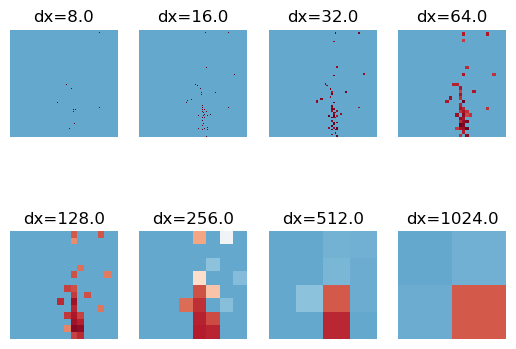

In [11]:
fig,axes = plt.subplots(2,4)
dx = s.domain['dx'][0]
for i,ax in enumerate(axes.flatten()):
    Sigma_down = rebin(Sigma_SFR,i)
    dmap = Sigma_down/Sigma_down.mean()-1

    plt.sca(ax)
    plt.imshow(dmap,norm=SymLogNorm(0.1,vmin=-100,vmax=100),
               cmap=plt.cm.RdBu_r,interpolation='nearest')
    plt.title('dx={}'.format(dx*2**i))
    plt.axis('off')

In [12]:
# gas projection maps
prj = s.read_prj(300)

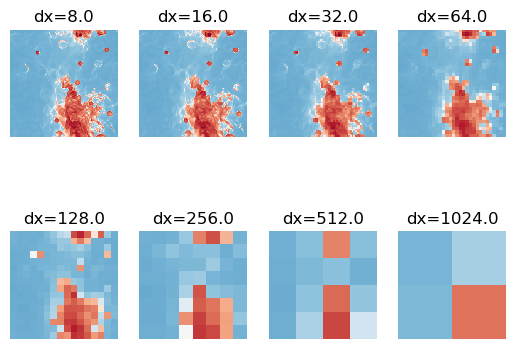

In [13]:
fig,axes = plt.subplots(2,4)
dx = s.domain['dx'][0]
for i,ax in enumerate(axes.flatten()):
    Sigma_down = rebin(prj['z']['EM'],i)
    dmap = Sigma_down/Sigma_down.mean()-1

    plt.sca(ax)
    plt.imshow(dmap,norm=SymLogNorm(0.1,vmin=-100,vmax=100),
               cmap=plt.cm.RdBu_r,interpolation='nearest')
    plt.title('dx={}'.format(dx*2**i))
    plt.axis('off')

In [14]:
def get_correlation(map1,map2=None,Nbin=8,return_map=False):
    """Calculate zero desplacement correlation value with different smoothing

    Parameters
    ==========
    map1 : array
    map2 : array
        if not specified, it will calculate auto correlation for map1
    return_map : bool
        if True, it will return maps rather than the correlation coefficient.
    overdensity definition:
        delta_L = (rho_L - <rho_L>)/<rho_L>

    zero-displacement auto correlation is basically a variance at scale L normalized by mean^2
    xi_L = <delta_L^2> = var_L/<rho_L>^2
    """
    corr=[]
    if return_map:
        maps = []
    for i in range(Nbin):
        submap1 = rebin(map1,i)
        dmap1 = (submap1-submap1.mean())/submap1.mean()
        if map2 is not None:
            submap2 = rebin(map2,i)
            dmap2 = (submap2-submap2.mean())/submap2.mean()
        else:
            dmap2 = dmap1
        corr.append((dmap1*dmap2).mean())
        if return_map: maps.append(dmap1*dmap2)
    if return_map:
        return maps

    return corr

def get_pearson_correlation(map1,map2=None,Nbin=8,return_map=False):
    """Calculate pearson correlation coefficient
    https://en.wikipedia.org/wiki/Pearson_correlation_coefficient

    Parameters
    ==========
    map1 : array
    map2 : array
        if not specified, it will calculate auto correlation for map1
    return_map : bool
        if True, it will return maps rather than the correlation coefficient.
    overdensity definition:
        delta_L = (rho_L - <rho_L>)/sigma_L,

        where stardard deviation at L is defined by
        sigma_L^2 = <(rho_L - <rho_L>)^2>

    r = <delta_L,1 * delta_L,2> = <(rho_L,1-<rho_L,1>)*(rho_L,2-<rho_L,2>)>/(sigma_L,1*sigma_L,2)
    """
    corr=[]
    if return_map:
        maps = []
    for i in range(Nbin):
        submap1 = rebin(map1,i)
        dmap1 = (submap1-submap1.mean())/submap1.std()
        if map2 is not None:
            submap2 = rebin(map2,i)
            dmap2 = (submap2-submap2.mean())/submap2.std()
        else:
            dmap2 = dmap1
        corr.append((dmap1*dmap2).mean())
        if return_map: maps.append(dmap1*dmap2)
    if return_map:
        return maps

    return corr

2.5240533
2.5499148
2.6216497
2.5587764
2.350473
2.0246344
1.6706226
0.8490211


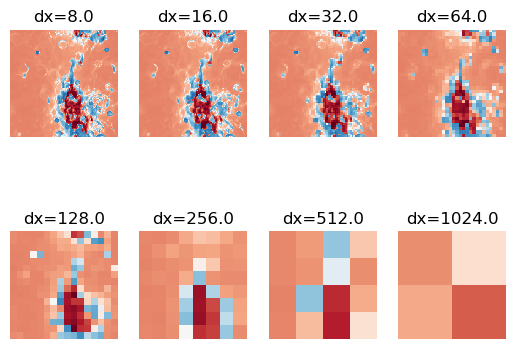

In [15]:
# correlation based on variance (zero-displacement two-point correlation)

maps = get_correlation(prj['z']['Sigma_H2'],prj['z']['EM'],return_map=True)

fig,axes = plt.subplots(2,4)
dx = s.domain['dx'][0]
for i,ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.imshow(maps[i],norm=SymLogNorm(0.1,vmin=-100,vmax=100),
               cmap=plt.cm.RdBu_r,interpolation='nearest')
    print(maps[i].mean())
    plt.title('dx={}'.format(dx*2**i))
    plt.axis('off')

0.24299511
0.26739702
0.32037386
0.40260816
0.49079642
0.628139
0.7382716
0.98896337


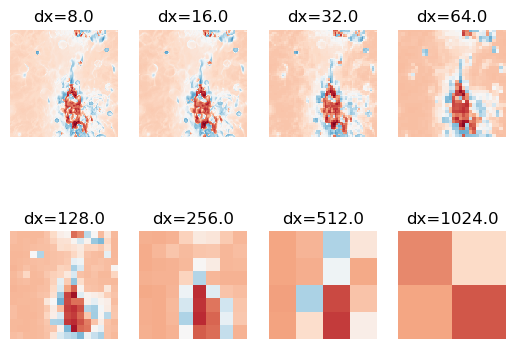

In [16]:
# Pearson correlation coefficient

maps = get_pearson_correlation(prj['z']['Sigma_H2'],prj['z']['EM'],return_map=True)

fig,axes = plt.subplots(2,4)
dx = s.domain['dx'][0]
for i,ax in enumerate(axes.flatten()):
    plt.sca(ax)
    plt.imshow(maps[i],norm=SymLogNorm(0.1,vmin=-100,vmax=100),
               cmap=plt.cm.RdBu_r,interpolation='nearest')
    print(maps[i].mean())
    plt.title('dx={}'.format(dx*2**i))
    plt.axis('off')

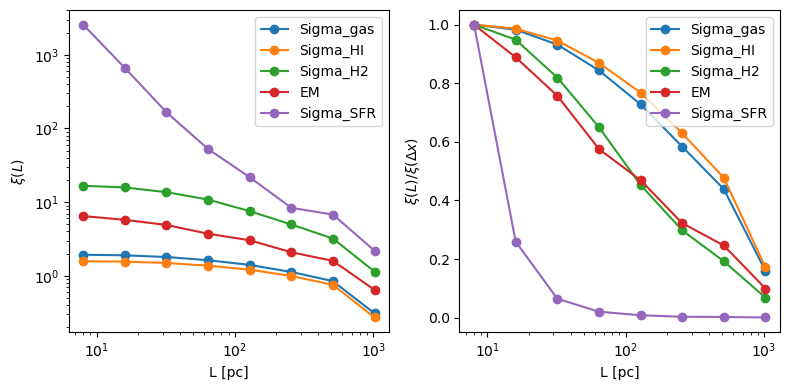

In [20]:
num = 300
prj = s.read_prj(num)
sp = s.load_starpar_vtk(num)
x,y,Sigma_SFR = get_Sigma_SFR(s,sp)
data = prj['z']
data['Sigma_SFR'] = Sigma_SFR
Nbin=8
L = s.domain['dx'][0]*2**np.arange(Nbin)

fig,axes = plt.subplots(1,2,figsize=(8,4))
# auto correlation
for f in ['Sigma_gas','Sigma_HI','Sigma_H2','EM','Sigma_SFR']:
    corr = get_correlation(data[f],return_map=False)
    plt.sca(axes[0])
    # un-normalized
    plt.plot(L,corr,'o-',label=f,)
    plt.ylabel(r'$\xi(L)$')
    plt.yscale('log')

    plt.sca(axes[1])
    # normalized
    plt.plot(L,corr/corr[0],'o-',label=f,)
    plt.ylabel(r'$\xi(L)/\xi(\Delta x)$')

for ax in axes:
    plt.sca(ax)
    plt.xscale('log')
    plt.legend()
    plt.xlabel('L [pc]')
plt.tight_layout()

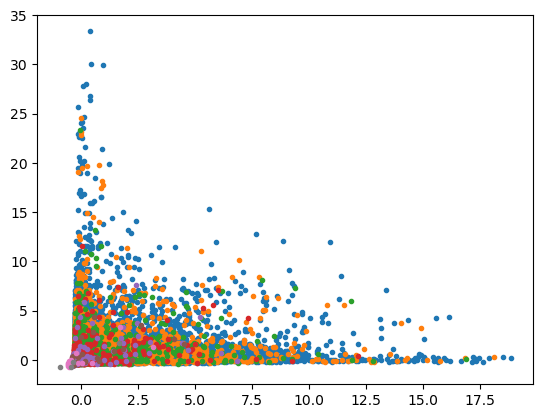

In [22]:
dx = s.domain['dx'][0]
map1 = data['Sigma_H2']
map2 = data['EM']
for i in range(8):
    submap1 = rebin(map1,i)
    dmap1 = (submap1-submap1.mean())/submap1.std()
    submap2 = rebin(map2,i)
    dmap2 = (submap2-submap2.mean())/submap2.std()
    plt.plot(dmap1.flatten(),dmap2.flatten(),'.')


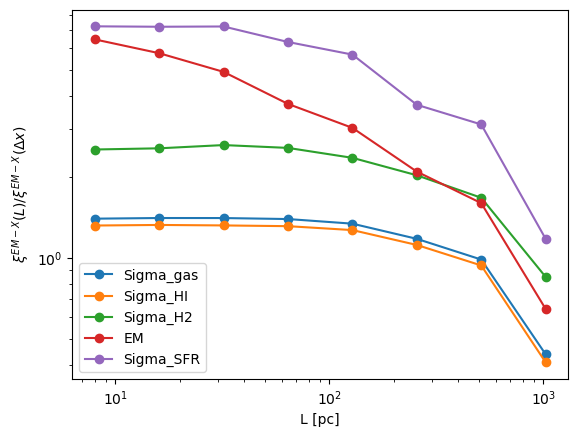

In [21]:
num = 300
prj = s.read_prj(num)
sp = s.load_starpar_vtk(num)
x,y,Sigma_SFR = get_Sigma_SFR(s,sp)
data = prj['z']
data['Sigma_SFR'] = Sigma_SFR
Nbin=8
L = s.domain['dx'][0]*2**np.arange(Nbin)

# cross correlation with EM
fref = 'EM'
for f in ['Sigma_gas','Sigma_HI','Sigma_H2','EM','Sigma_SFR']:
    corr = get_correlation((data[fref]),(data[f]),return_map=False)
    plt.plot(L,corr,'o-',label=f,)
plt.xscale('log')
plt.legend()
plt.xlabel('L [pc]')
plt.ylabel(r'$\xi^{EM-X}(L)/\xi^{EM-X}(\Delta x)$')
plt.yscale('log')

# Exmaple Analysis of time series

In [23]:
Nnums = len(s.nums)
corr = dict()
for j,num in enumerate(s.nums):
    prj = s.read_prj(num)
    sp = s.load_starpar_vtk(num)
    x,y,Sigma_SFR = get_Sigma_SFR(s,sp)
    data = prj['z']
    data['Sigma_SFR'] = Sigma_SFR

    # autocorrelation
    for f in ['Sigma_gas','Sigma_HI','Sigma_H2','EM','Sigma_SFR']:
        if f not in corr:
            corr[f] = [] # initialization
        corr[f].append(get_correlation(data[f],return_map=False))
# make list to numpy array
for f in corr:
    corr[f] = np.array(corr[f])

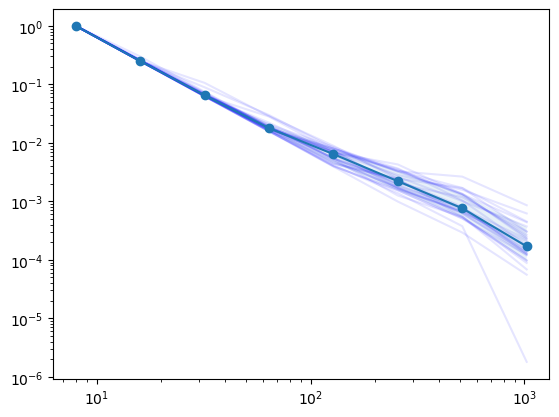

In [24]:
plt.plot(L,corr[f].T/corr[f][:,0],color='b',alpha=0.1);
y_series = corr[f].T/corr[f][:,0]
y = np.percentile(y_series,[16,50,84],axis=1)
plt.fill_between(L,y[0],y[2],alpha=0.1)
plt.plot(L,y[1],'o-')
# plt.plot(L,corr[f].mean(axis=0)/corr[f].mean(axis=0)[0],'o-',color='b');
plt.yscale('log')
plt.xscale('log')